 # Tutorial for Gromov-Wassserstein unsupervised alignment 

In [127]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../'))

import numpy as np
import pandas as pd
import pickle as pkl
import torch

from src.align_representations import Representation, AlignRepresentations, OptimizationConfig, VisualizationConfig

# Step1: Prepare dissimilarity matrices or embeddings from the data
First, you need to prepare dissimilarity matrices or embeddings from your data.  
To store dissimilarity matrices or embeddings, an instance of the class `Representation` is used.   
Please put your dissimilarity matrices or embeddings into the variables `sim_mat` or `embedding` in this instance.   

## Load data
`simulation`: Synthetic data illustrating difference between supervised an unsupervised alignment    

In [128]:
# list of representations where the instances of "Representation" class are included
representations = list()

# select data : "simulation", "AllenBrain", "THINGS", "DNN", "color"
data_select = "simulation"

### Dataset No.1 `difficulty`

In [ ]:
# correlation = 0.9 # 0.9, 0.8, 0.7
n_clusters = 10

# data_select += f"_corr{correlation}"
data_select += f"_clusters{n_clusters}"

n_representations = 2 # Set the number of the instanses of "Representation". This number must be equal to or less than the number of the groups. 2 is the maximum for this data.
metric = "euclidean" # Please set the metric that can be used in "scipy.spatical.distance.cdist()".

for i in range(n_representations):
    name = f"Group{i+1}" # the name of the representation
    # embedding = np.load(f"../../data/difficulty/corr{correlation}/embedding_{i+1}.npy") # the dissimilarity matrix will be computed with this embedding based on the metric
    embedding = np.load(f"../../data/difficulty/clusters{n_clusters}/embedding_{i+1}.npy") # the dissimilarity matrix will be computed with this embedding based on the metric
    
    representation = Representation(
        name=name,
        embedding=embedding,
        metric=metric,
        get_embedding=False, # If there is the embeddings, plese set this variable "False".
    )
    
    representations.append(representation)

# Step 2: Set the parameters for the optimazation of GWOT
Second, you need to set the parameters for the optimization of GWOT.    
For most of the parameters, you can start with the default values.   
However, there are some essential parameters that you need to check for your original applications.  

## Optimization Config  

#### Most important parameters to check for your application:
`eps_list`: The range of the values of epsilon for entropic GWOT.   
If epsilon is not in appropriate ranges (if it is too low), the optimization may not work properly.   
Although the algorithm will find good epsilon values after many trials, it is a good practice to narrow down the range beforehand.   

`num_trial`: The number of trials to test epsilon values from the specified range.   
This number directly determines the quality of the unsupervised alignment.   
You should set this number high enough to find good local minima. 

In [ ]:
eps_list_tutorial = [0.1, 10]
device = 'cpu'
to_types = 'numpy'
multi_gpu = False

# whether epsilon is sampled at log scale or not
eps_log = True

# set the number of trials, i.e., the number of epsilon values evaluated in optimization. default : 4
num_trial = 100

init_mat_plan = "uniform"
sampler_name = "grid"

main_results_dir = "../../results/" + data_select
if sampler_name == "grid" and init_mat_plan == "random":
    main_results_dir = main_results_dir + f"/random+grid/"

In [131]:
config = OptimizationConfig(    
    eps_list = eps_list_tutorial,
    eps_log = eps_log,
    num_trial = num_trial,
    sinkhorn_method='sinkhorn', 
    
    ### Set the device ('cuda' or 'cpu') and variable type ('torch' or 'numpy')
    to_types = to_types, # user can choose "numpy" or "torch". please set "torch" if one wants to use GPU.
    device = device, # "cuda" or "cpu"; for numpy, only "cpu" can be used. 
    data_type = "double", # user can define the dtypes both for numpy and torch, "float(=float32)" or "double(=float64)". For using GPU with "sinkhorn", double is storongly recommended.
    
    ### Parallel Computation (requires n_jobs > 1, available both for numpy and torch)
    n_jobs = 1, # n_jobs : the number of worker to compute. if n_jobs = 1, normal computation will start. "Multithread" is used for Parallel computation.
    multi_gpu = multi_gpu, # This parameter is only for "torch". # "True" : all the GPU installed in your environment are used, "list (e.g.[0,2,3])"" : cuda:0,2,3, and "False" : single gpu (or cpu for numpy) will use.

    db_params={"drivername": "sqlite"},
    # db_params={"drivername": "mysql+pymysql", "username": "root", "password": "****", "host": "localhost"},
    
    ### Set the parameters for optimization
    # 'uniform': uniform matrix, 'diag': diagonal matrix', random': random matrix
    init_mat_plan = init_mat_plan,
    
    n_iter = 1,
    max_iter = 1000,
    
    sampler_name = sampler_name,
    pruner_name = 'hyperband',
    pruner_params = {'n_startup_trials': 1, 
                     'n_warmup_steps': 2, 
                     'min_resource': 2, 
                     'reduction_factor' : 3
                    },
)

## Step 3 : Gromov-Wasserstein Optimal Transport (GWOT) between Representations
Third, you perform GWOT between the instanses of "Representation", by using the class `AlignRepresentations`.  
This class has methods for the optimization of entropic Gromov-Wasserstein distance, and the evaluation of the GWOT (Step 4).  
This class also has a method to perform conventional Representation Similarity Analysis (RSA).   

In [132]:
# Create an "AlignRepresentations" instance
align_representation = AlignRepresentations(
    config=config,
    representations_list=representations,   
   
    # histogram matching : this will adjust the histogram of target to that of source.
    histogram_matching=False,

    # main_results_dir : folder or file name when saving the result
    main_results_dir = main_results_dir,
   
    # data_name : Please rewrite this name if users want to use their own data.
    data_name = data_select,
)

data_name : simulation_corr0.9
pairwise_method : combination
All the pairs in the list below will be computed. 
pair: Group1_vs_Group2 eps_list: [1, 10]


## Show dissimilarity matrices

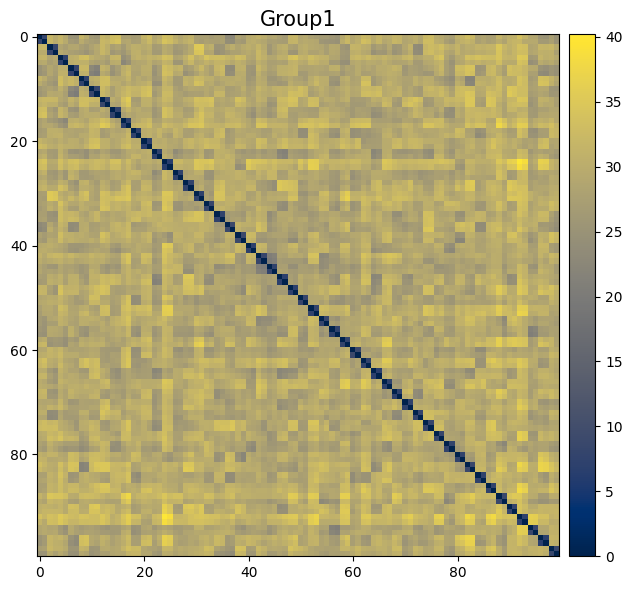

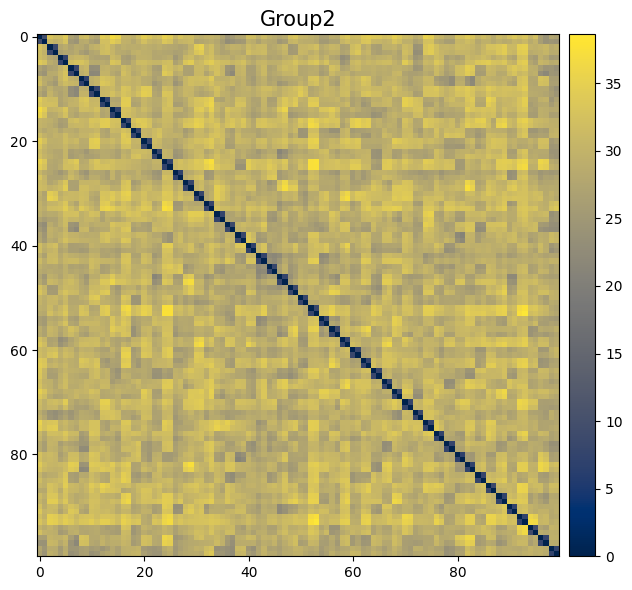

In [133]:
sim_mat_format = "default"

visualize_config = VisualizationConfig(
    figsize=(8, 6), 
    title_size = 15, 
    ot_object_tick=True,
)

visualize_hist = VisualizationConfig(figsize=(8, 6), color='C0')

sim_mat = align_representation.show_sim_mat(
    sim_mat_format = sim_mat_format, 
    visualization_config = visualize_config,
    visualization_config_hist = visualize_hist,
    show_distribution=False, # if True, the histogram figure of the sim_mat will be shown. visualization_config_hist will be used for adjusting this figure.
)

## Reperesentation Similarity Aanalysis (RSA)
This performs a conventional representation similarity analysis.

In [134]:
### parameters for computing RSA
# metric = "pearson" or "spearman" by scipy.stats
# The result of RSA for each pair will be stored in align_representation.RSA_corr
align_representation.RSA_get_corr(metric = "pearson")

# print(align_representation.RSA_corr)

Correlation Group1 vs Group2 : 0.8820813114688318


## GWOT
The optimization results are saved in the folder named "config.data_name" + "representations.name" vs "representation.name".  
If you want to change the name of the saved folder, please make changes to "config.data_name" and "representations.name" (or change the "filename" in the code block below).

GWOT is performed by appling the method `gw_alignment` to the instance of `AlignRepresentations` class.

We show all the parameters to run GWOT computation as an example with THINGS or DNN dataset because these dataset have category information label.

For the dataset of color, AllenBrain, and simulation (these doesn’t have the category information), we show how to do this in next cell. 

Here is the example to compute the GWOT for each pair for color, AllenBrain, and simulation datasets below.

In [135]:
compute_OT = True

In [136]:
visualize_config = VisualizationConfig(
    show_figure=True,
    figsize=(8, 6), 
    title_size = 15, 
    ot_object_tick=True,
    plot_eps_log=eps_log,
)

sim_mat_format = "default"

align_representation.gw_alignment(
    compute_OT = compute_OT,
    delete_results = False,
    return_data = False,
    return_figure = False,
    OT_format = sim_mat_format,
    visualization_config = visualize_config,
)

Study for simulation_corr0.9_Group1_vs_Group2_uniform was not found, creating a new one...


[I 2024-12-23 17:41:04,512] A new study created in RDB with name: simulation_corr0.9_Group1_vs_Group2_uniform


  0%|          | 0/1 [00:00<?, ?it/s]

/home1/user/ken-takeda/GWTune/.venv/lib/python3.9/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
[I 2024-12-23 17:41:08,723] Trial 0 finished with value: 6.315613215719294 and parameters: {'eps': 6.892612104349698}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:10,181] Trial 1 finished with value: 7.756174630534975 and parameters: {'eps': 3.4304692863149184}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:12,084] Trial 2 finished with value: 6.7621634091937075 and parameters: {'eps': 5.09413801481638}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:13,546] Trial 3 finished with value: 7.420282686264493 and parameters: {'eps': 2.848035868435802}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:15,014] Trial 4 finished with value: 7.414722738047647 and parameters: {'eps': 2.782559402207125}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:16,840] Trial 5 finished with value: 7.954817560409585 and parameters: {'eps': 2.477076355991711}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:20,110] Trial 6 finished with value: 8.025038282428667 and parameters: {'eps': 1.6681005372000588}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:22,591] Trial 7 finished with value: 6.98534779800912 and parameters: {'eps': 6.428073117284322}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:29,290] Trial 8 finished with value: 7.898186471386472 and parameters: {'eps': 1.2618568830660204}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:37,150] Trial 9 finished with value: 9.605768542917746 and parameters: {'eps': 1.0}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:41,079] Trial 10 finished with value: 8.049944221937533 and parameters: {'eps': 1.5199110829529336}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:43,229] Trial 11 finished with value: 8.055066019003501 and parameters: {'eps': 2.0092330025650473}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:45,060] Trial 12 finished with value: 6.558083438565756 and parameters: {'eps': 5.462277217684343}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:46,967] Trial 13 finished with value: 8.073095031492407 and parameters: {'eps': 2.154434690031884}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:49,825] Trial 14 finished with value: 33.796030205706 and parameters: {'eps': 8.111308307896872}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:55,470] Trial 15 finished with value: 8.880940414252082 and parameters: {'eps': 1.0974987654930561}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:57,616] Trial 16 finished with value: 6.601089521866482 and parameters: {'eps': 5.857020818056667}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:41:59,756] Trial 17 finished with value: 6.89639472383017 and parameters: {'eps': 5.99484250318941}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:09,703] Trial 18 finished with value: 7.933544738841055 and parameters: {'eps': 1.321941148466029}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:11,730] Trial 19 finished with value: 8.045097830729002 and parameters: {'eps': 2.0565123083486516}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:13,265] Trial 20 finished with value: 7.61792338877984 and parameters: {'eps': 3.5938136638046276}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:16,043] Trial 21 finished with value: 32.315853881682095 and parameters: {'eps': 7.742636826811272}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:19,060] Trial 22 finished with value: 8.447172490935028 and parameters: {'eps': 1.8307382802953682}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:20,925] Trial 23 finished with value: 7.7885975075716605 and parameters: {'eps': 2.6560877829466865}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:22,859] Trial 24 finished with value: 6.94857240564097 and parameters: {'eps': 4.977023564332112}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:27,336] Trial 25 finished with value: 8.002736582329508 and parameters: {'eps': 1.4174741629268053}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:29,529] Trial 26 finished with value: 8.259280965331563 and parameters: {'eps': 2.535364493970112}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:30,540] Trial 27 finished with value: 36.11235552847017 and parameters: {'eps': 9.326033468832199}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:37,591] Trial 28 finished with value: 7.880203514560677 and parameters: {'eps': 1.2328467394420661}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:39,453] Trial 29 finished with value: 6.622648705951981 and parameters: {'eps': 5.3366992312063095}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:48,475] Trial 30 finished with value: 7.916053561631301 and parameters: {'eps': 1.2915496650148839}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:49,951] Trial 31 finished with value: 7.431038953763958 and parameters: {'eps': 2.9836472402833394}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:42:57,647] Trial 32 finished with value: 6.662861697810934 and parameters: {'eps': 7.220809018385466}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:00,335] Trial 33 finished with value: 7.958828874255283 and parameters: {'eps': 1.9179102616724888}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:01,873] Trial 34 finished with value: 35.922833613688006 and parameters: {'eps': 8.697490026177835}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:07,370] Trial 35 finished with value: 9.372281118939743 and parameters: {'eps': 1.1233240329780274}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:08,927] Trial 36 finished with value: 7.468084212898803 and parameters: {'eps': 4.641588833612779}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:10,822] Trial 37 finished with value: 7.42631974900726 and parameters: {'eps': 4.534878508128582}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:12,734] Trial 38 finished with value: 8.0883417725205 and parameters: {'eps': 2.25701971963392}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:16,852] Trial 39 finished with value: 8.019047395018799 and parameters: {'eps': 1.4508287784959397}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:18,418] Trial 40 finished with value: 7.441433087665272 and parameters: {'eps': 3.1257158496882362}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:20,334] Trial 41 finished with value: 8.08083284862137 and parameters: {'eps': 2.205130739903046}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:26,417] Trial 42 finished with value: 7.844311272475899 and parameters: {'eps': 1.1768119524349985}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:27,578] Trial 43 finished with value: 36.050888849965084 and parameters: {'eps': 9.111627561154894}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:30,587] Trial 44 finished with value: 8.015493791597528 and parameters: {'eps': 1.873817422860384}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:34,238] Trial 45 finished with value: 8.064549585860009 and parameters: {'eps': 1.5556761439304718}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:37,079] Trial 46 finished with value: 6.973362708603109 and parameters: {'eps': 6.579332246575681}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:40,001] Trial 47 finished with value: 8.022133623643196 and parameters: {'eps': 1.788649529057435}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:41,494] Trial 48 finished with value: 7.550144909853703 and parameters: {'eps': 4.229242874389499}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:48,858] Trial 49 finished with value: 7.950499731850927 and parameters: {'eps': 1.353047774579807}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:51,751] Trial 50 finished with value: 8.010679468173606 and parameters: {'eps': 1.7475284000076838}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:43:56,083] Trial 51 finished with value: 9.289263136574291 and parameters: {'eps': 1.0722672220103233}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:00,116] Trial 52 finished with value: 8.034782709256666 and parameters: {'eps': 1.484968262254465}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:01,992] Trial 53 finished with value: 8.03586014126676 and parameters: {'eps': 2.420128264794382}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:09,082] Trial 54 finished with value: 7.8622046598847 and parameters: {'eps': 1.2045035402587823}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:11,258] Trial 55 finished with value: 7.0697600640210805 and parameters: {'eps': 6.135907273413174}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:15,917] Trial 56 finished with value: 8.18523344523975 and parameters: {'eps': 1.1497569953977358}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:17,435] Trial 57 finished with value: 7.400129237616437 and parameters: {'eps': 4.430621457583881}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:19,319] Trial 58 finished with value: 8.095629357856394 and parameters: {'eps': 2.3101297000831598}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:22,542] Trial 59 finished with value: 32.49935551104545 and parameters: {'eps': 7.924828983539175}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:24,014] Trial 60 finished with value: 7.59225537076524 and parameters: {'eps': 3.6783797718286344}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:24,962] Trial 61 finished with value: 36.921082077789805 and parameters: {'eps': 10.0}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:26,464] Trial 62 finished with value: 7.715569400452431 and parameters: {'eps': 3.511191734215132}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:28,347] Trial 63 finished with value: 7.616559030562935 and parameters: {'eps': 2.718588242732941}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:29,832] Trial 64 finished with value: 7.44654764113859 and parameters: {'eps': 3.1992671377973836}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:31,666] Trial 65 finished with value: 7.354990736220071 and parameters: {'eps': 4.7508101621027965}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:33,175] Trial 66 finished with value: 7.425715701653147 and parameters: {'eps': 2.915053062825177}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:34,998] Trial 67 finished with value: 6.804062082568243 and parameters: {'eps': 4.862601580065355}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:36,854] Trial 68 finished with value: 7.4090764891240894 and parameters: {'eps': 4.132012400115338}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:37,879] Trial 69 finished with value: 36.17529043539108 and parameters: {'eps': 9.545484566618342}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:40,391] Trial 70 finished with value: 6.961061004702651 and parameters: {'eps': 6.280291441834253}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:42,298] Trial 71 finished with value: 7.920743307178576 and parameters: {'eps': 2.5950242113997364}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:43,808] Trial 72 finished with value: 7.603934098991619 and parameters: {'eps': 3.8535285937105295}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:45,288] Trial 73 finished with value: 7.436271191213811 and parameters: {'eps': 3.0538555088334154}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:47,021] Trial 74 finished with value: 36.867817760487455 and parameters: {'eps': 9.770099572992255}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:48,483] Trial 75 finished with value: 7.548564570393494 and parameters: {'eps': 3.7649358067924683}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:50,660] Trial 76 finished with value: 6.5826166315200565 and parameters: {'eps': 5.722367659350219}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:52,556] Trial 77 finished with value: 8.441548440271205 and parameters: {'eps': 2.1049041445120205}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:53,834] Trial 78 finished with value: 35.988858750673444 and parameters: {'eps': 8.902150854450388}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:55,326] Trial 79 finished with value: 7.610548127001547 and parameters: {'eps': 3.944206059437656}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:44:57,204] Trial 80 finished with value: 7.453256511768375 and parameters: {'eps': 4.328761281083059}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:02,208] Trial 81 finished with value: 6.571704982775342 and parameters: {'eps': 7.054802310718643}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:04,142] Trial 82 finished with value: 8.102703008797501 and parameters: {'eps': 2.3644894126454075}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:06,377] Trial 83 finished with value: 8.045009279186234 and parameters: {'eps': 1.9630406500402708}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:10,389] Trial 84 finished with value: 8.667445119425722 and parameters: {'eps': 1.0235310218990261}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:11,873] Trial 85 finished with value: 7.750979038509399 and parameters: {'eps': 3.3516026509388426}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:15,146] Trial 86 finished with value: 8.571902373307609 and parameters: {'eps': 1.6297508346206442}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:18,802] Trial 87 finished with value: 8.681288171940576 and parameters: {'eps': 1.0476157527896648}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:22,089] Trial 88 finished with value: 8.037076216344447 and parameters: {'eps': 1.7073526474706908}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:25,622] Trial 89 finished with value: 32.139050466964335 and parameters: {'eps': 7.56463327554629}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:29,811] Trial 90 finished with value: 34.54813077042499 and parameters: {'eps': 8.302175681319746}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:31,656] Trial 91 finished with value: 6.645507412978083 and parameters: {'eps': 5.590810182512224}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:36,701] Trial 92 finished with value: 31.96031496091037 and parameters: {'eps': 7.390722033525779}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:39,943] Trial 93 finished with value: 7.111689949845884 and parameters: {'eps': 6.734150657750823}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:43,270] Trial 94 finished with value: 8.07862070852609 and parameters: {'eps': 1.5922827933410924}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:44,774] Trial 95 finished with value: 7.519706829690163 and parameters: {'eps': 4.0370172585965545}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:46,613] Trial 96 finished with value: 6.604026351678811 and parameters: {'eps': 5.214008287999686}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:51,264] Trial 97 finished with value: 7.985868321766512 and parameters: {'eps': 1.384886371393873}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:53,231] Trial 98 finished with value: 35.84513593166957 and parameters: {'eps': 8.497534359086444}. Best is trial 0 with value: 6.315613215719294.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-12-23 17:45:54,745] Trial 99 finished with value: 7.451640587198216 and parameters: {'eps': 3.274549162877729}. Best is trial 0 with value: 6.315613215719294.


# Step 4: Evaluation and Visualization
Finally, you can evaluate and visualize the unsupervise alignment of GWOT.   

## Show how the GWD was optimized
`show_optimization_log` will make two figures to show both the relationships between epsilons (x-axis) and GWD (y-axis), and between accuracy (x-axis) and GWD (y-axis).



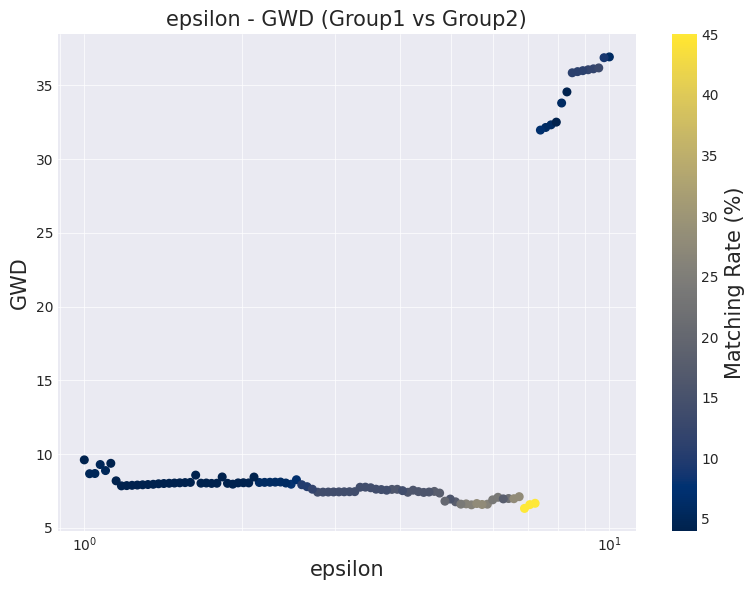

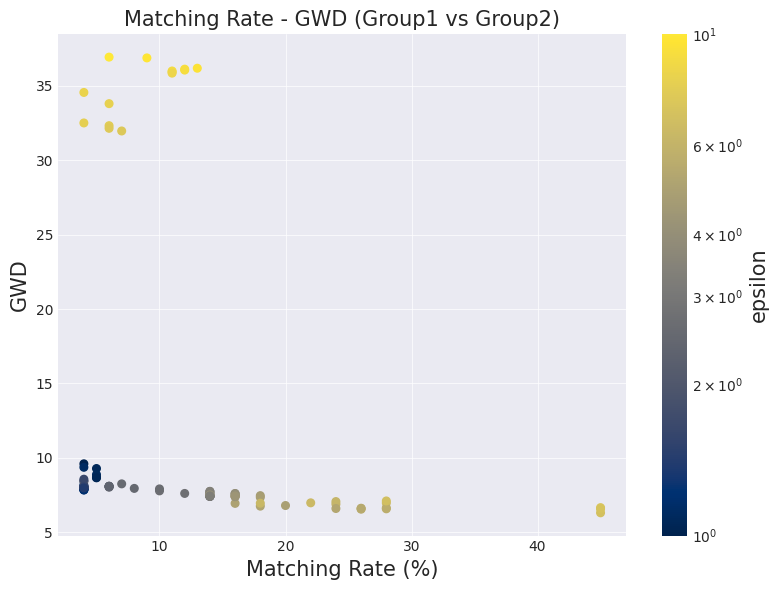

In [137]:
### Show how the GWD was optimized (evaluation figure)
# show both the relationships between epsilons and GWD, and between accuracy and GWD
align_representation.show_optimization_log(fig_dir=None, visualization_config=visualize_config) 

## Evaluation of the accuracy of the unsupervised alignment
There are two ways to evaluate the accuracy.  
1. Calculate the accuracy based on the OT plan. 
- For using this method, please set the parameter `eval_type = "ot_plan"` in "calc_accuracy()".
  
2. Calculate the matching rate based on the k-nearest neighbors of the embeddings.
-  For using this method, please set the parameter `eval_type = "k_nearest"` in "calc_accuracy()".

For both cases, the accuracy evaluation criterion can be adjusted by considering "top k".  
By setting "top_k_list", you can observe how the accuracy increases as the criterion is relaxed.

Top k accuracy : 
        Group1_vs_Group2
top_n                  
1                  45.0
5                  91.0
10                 96.0

Mean : 
 top_n
1    NaN
5    NaN
10   NaN
dtype: float64


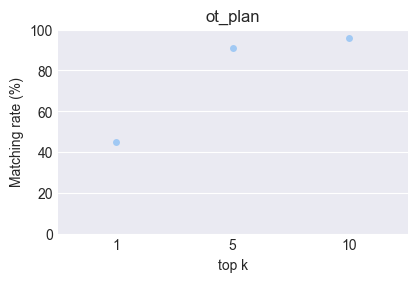

In [138]:
## Calculate the accuracy based on the OT plan. 
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "ot_plan")
align_representation.plot_accuracy(eval_type = "ot_plan", scatter = True)

top_k_accuracy = align_representation.top_k_accuracy # you can get the dataframe directly 

K nearest matching rate : 
        Group1_vs_Group2
top_n                  
1                  39.0
5                  84.0
10                 92.0

Mean : 
 top_n
1    NaN
5    NaN
10   NaN
dtype: float64


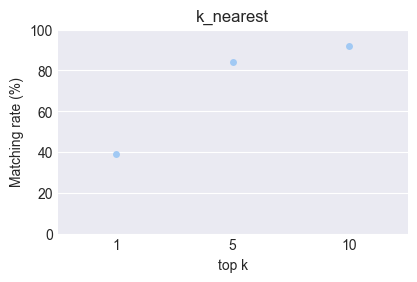

In [139]:
## Calculate the matching rate based on the k-nearest neighbors of the embeddings.
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "k_nearest", metric=metric)
align_representation.plot_accuracy(eval_type = "k_nearest", scatter = True)

k_nearest_matching_rate = align_representation.k_nearest_matching_rate # you can get the dataframe directly 

## Procrustes Analysis
Using optimized transportation plans, you can align the embeddings of each representation to a shared space in an unsupervised manner.  
The `"pivot"` refers to the target embeddings space to which the other embeddings will be aligned.   
You have the option to designate the `"pivot"` as one of the representations or the barycenter.  
Please ensure that 'pair_number_list' includes all pairs between the pivot and the other Representations.  

If you wish to utilize the barycenter, please make use of the method `AlignRepresentation.barycenter_alignment()`.  
You can use it in the same manner as you did with `AlignRepresentation.gw_alignment()`.

No category information is given.


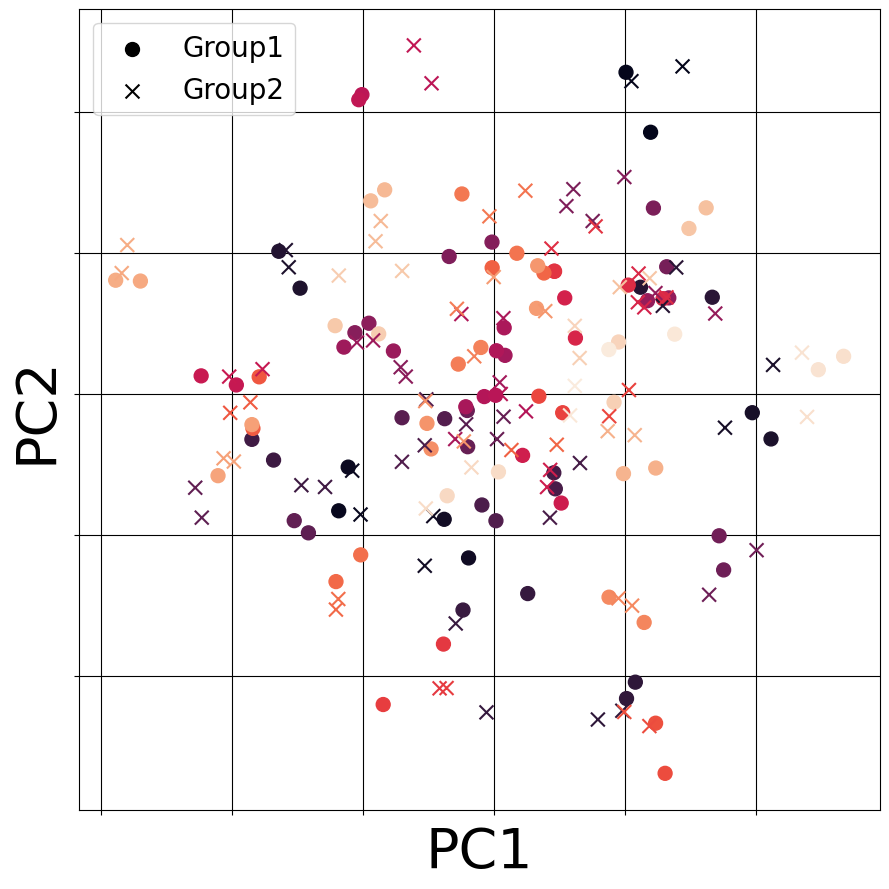

In [140]:
emb_name = "PCA" #"TSNE", "PCA", "MDS"

visualization_embedding = VisualizationConfig(
    fig_ext='svg',
    figsize=(9, 9), 
    xlabel="PC1",
    ylabel="PC2", 
    marker_size=100,
    xlabel_size=40,
    ylabel_size=40,
    legend_size=20,
)

align_representation.visualize_embedding(
    dim=2, # the dimensionality of the space the points are embedded in. You can choose either 2 or 3.
    pivot=0, # the number of one of the representations or the "barycenter".
    visualization_config=visualization_embedding
)

## (Option) Visualize the aligned embeddings
It is helpful to visually inspect the quality of the unsupervised alignment by plotting the aligned embeddings in 2D or 3D space. 

Using the optimal transportation plan $\Gamma∗$, one set of embeddings $X$, 
and the other set of aligned embeddings are obtained by performing matrix product of the $\Gamma*$ and $X$. 

This $\Gamma* X$ means the new embedding to represent the other set of embedding $Y$ in the space of $X$. 

Next, the embedding of $X$ and new embedding of $Y$ ($Γ∗X$) in the space of $X$ are concatenated in the axis of the number of embeddings (e.g. experimental stimuli, and so on).  
Then, for example, Principle Components Analysis (PCA) is used to project high-dimensional embeddings into 2D or 3D space, but other dimensionality reduction methods are also applicable. 

And, each one of the two embeddings were plotted in 3D figure after splitting the data into the two embeddings. 
If there is a known correspondence between the embeddings, the user can visually check whether the aligned embeddings are positioned close to the corresponding embeddings.

In [141]:
pair = align_representation.pairwise_list[0]

ot = pair.OT

# plt.imshow(ot, cmap='viridis')
# plt.show()

In [142]:
source = pair.source.embedding
target = pair.target.embedding

new_source = pair.OT.T @ target * len(target)
new_target = pair.OT @ source * len(source)

In [143]:
new_rep_list = [
    Representation(name="Group1", embedding=source),
    Representation(name="Group2", embedding=new_target),
]

ar = AlignRepresentations(
    config=config,
    representations_list=new_rep_list,
    histogram_matching=False,
    # metric="cosine",
    main_results_dir="../../results/" + data_select,
    data_name=data_select,
)

data_name : simulation_corr0.9
pairwise_method : combination
All the pairs in the list below will be computed. 
pair: Group1_vs_Group2 eps_list: [1, 10]


No category information is given.


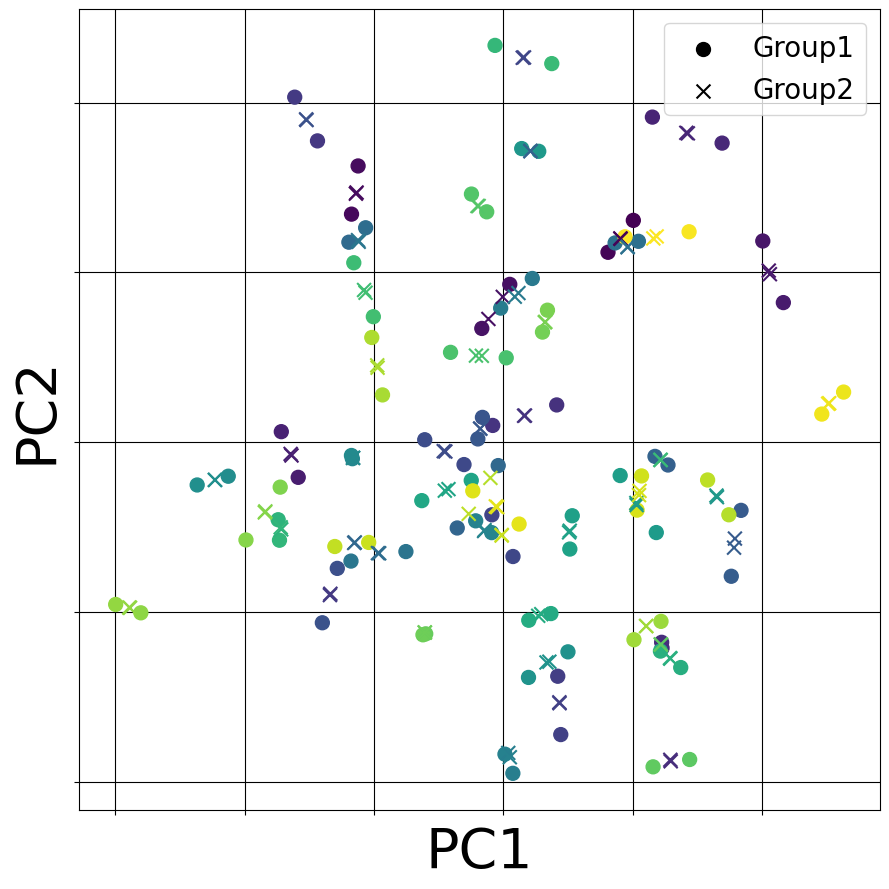

In [144]:
emb_name = "PCA" #"TSNE", "PCA", "MDS"

visualization_embedding = VisualizationConfig(
    fig_ext='svg',
    figsize=(9, 9), 
    xlabel="PC1",
    ylabel="PC2", 
    marker_size=100,
    xlabel_size=40,
    ylabel_size=40,
    legend_size=20,
)

ar.visualize_embedding(
    dim=2, # the dimensionality of the space the points are embedded in. You can choose either 2 or 3.
    method=emb_name, # the method used to embed the points. You can choose either "PCA", "TSNE", or "MDS".
    pivot=None, 
    visualization_config=visualization_embedding
)